In [ ]:
"""
This program does sentiment analysis of IMDB movie review dataset using LSTM
It classifies a movie review as positive or negative
Dataset : https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
Reference: https://www.kaggle.com/code/arunmohan003/sentiment-analysis-using-lstm-pytorch/notebook
Executed on Google Colab with GPU, with Python 3.7.12 and PyTorch 1.10.0 
"""

In [324]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
from nltk.corpus import stopwords 
from collections import Counter
import re
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import nltk
from nltk.stem import WordNetLemmatizer

In [325]:
# Initialize variables 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
MAX_LEN = 1000
learning_rate = 0.001

In [326]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/gdrive')
# Load dataset  
data_dir = "/content/gdrive/My Drive/Data/Imdb/archive"
df = pd.read_csv(data_dir+"/IMDB Dataset.csv")
df.head() 

X,y = df['review'].values,df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11111111, stratify=y_train)

print(f'shape of train data is {X_train.shape}')
print(f'shape of test data is {X_test.shape}')
print(f'shape of val data is {X_val.shape}')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
shape of train data is (40000,)
shape of test data is (5000,)
shape of val data is (5000,)


In [327]:
# Pre-process sentences function
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with single space
    s = re.sub(r"\s+", ' ', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    # Convert to lower case
    s = s.lower()
    return s

In [328]:
# Define the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
# Define lemmatization function  
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

In [329]:
# Download stopwords and wordnet
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [330]:
# Function for stopwords removal, tokenization, and lemmatization
def tokenize_lemmatize(x_train, y_train, x_val, y_val, x_test, y_test):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # Sorting on the basis of most common words
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:10000]
    # Creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # Tokenize
    final_list_train, final_list_val, final_list_test = [], [], []
    for sent in x_train:
        # Tokenize
        token_list = sent.lower().split()
        # Lemmatize
        lemma_list = lemmatizer(token_list)
        final_list_train.append([onehot_dict[preprocess_string(word)] for word in lemma_list 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
        # Tokenize
        token_list = sent.lower().split()
        # Lemmatize
        lemma_list = lemmatizer(token_list)
        final_list_val.append([onehot_dict[preprocess_string(word)] for word in lemma_list 
                                    if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_test:
        # Tokenize
        token_list = sent.lower().split()
        # Lemmatize
        lemma_list = lemmatizer(token_list)
        final_list_test.append([onehot_dict[preprocess_string(word)] for word in lemma_list 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_val = [1 if label =='positive' else 0 for label in y_val] 
    encoded_test = [1 if label =='positive' else 0 for label in y_test] 
    
    x_train = np.array(final_list_train, dtype=object) 
    y_train = np.array(encoded_train)
    x_val = np.array(final_list_val, dtype=object)
    y_val = np.array(encoded_val)
    x_test = np.array(final_list_test, dtype=object) 
    y_test = np.array(encoded_test)
    
    return x_train, y_train, x_val, y_val, x_test, y_test, onehot_dict


In [331]:
# Call tokenize_lemmatize function
X_train, y_train, X_val, y_val, X_test, y_test, vocab = tokenize_lemmatize(X_train, y_train, X_val, y_val, X_test, y_test)


In [332]:
# Pad the sentences upto Max Length
def padding_(sentences, max_len):
    features = np.zeros((len(sentences), max_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:max_len]
    return features

In [333]:
# We have very less number of reviews with length > 1000.
# So we will consider only those below it.
X_train_pad = padding_(X_train, MAX_LEN)
X_val_pad = padding_(X_val, MAX_LEN)
X_test_pad = padding_(X_test, MAX_LEN)

# Create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_val_pad), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test_pad), torch.from_numpy(y_test))

# Create dataloaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)


In [334]:
# Define LSTM model
class SentimentLSTM(nn.Module):
    def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, drop_prob=0.5):
        super(SentimentLSTM, self).__init__()
 
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # Embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        # Dropout layer
        self.dropout = nn.Dropout(drop_prob)
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        # Embeddings and lstm_out
        embeds = self.embedding(x)  
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # Dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # Sigmoid function
        sig_out = self.sig(out)
        
        # Reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # Get last batch of labels
        
        # Return last sigmoid output and hidden state
        return sig_out, hidden
             
    # Initialize hidden state     
    def init_hidden(self, batch_size):
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden
    

In [335]:
no_layers = 2
vocab_size = len(vocab) + 1 # Extra 1 for padding
embedding_dim = 256
hidden_dim = 256
drop_prob = 0.5
# Create LSTM model
model = SentimentLSTM(no_layers, vocab_size, hidden_dim, embedding_dim, drop_prob)


In [336]:
# Moving to gpu if available
model.to(device)
print(model)

SentimentLSTM(
  (embedding): Embedding(10001, 256)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [337]:
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [338]:
# Function to calculate accuracy
def acc(pred, label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()


In [339]:
clip = 5
epochs = 5 
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

# Start training
for epoch in range(epochs):
    # Training
    train_losses = []
    train_acc = 0.0
    model.train()
    # Initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output, h = model(inputs, h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # Calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs/LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    # Validation     
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])
            inputs, labels = inputs.to(device), labels.to(device)
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())
            val_losses.append(val_loss.item())
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}') 
    print(25*'==')
 
print('Saving model...')
torch.save(model.state_dict(), 'state_dict.pt')    


Epoch 1
train_loss : 0.47940100588798523 val_loss : 0.3745753661944316
train_accuracy : 77.545 val_accuracy : 83.1
Epoch 2
train_loss : 0.3369128125667572 val_loss : 0.3367952941319881
train_accuracy : 86.36749999999999 val_accuracy : 85.58
Epoch 3
train_loss : 0.2586770431160927 val_loss : 0.3277714015581669
train_accuracy : 89.8175 val_accuracy : 86.66
Epoch 4
train_loss : 0.20636775119304657 val_loss : 0.31748669766462767
train_accuracy : 92.35 val_accuracy : 87.44
Epoch 5
train_loss : 0.15610490552186965 val_loss : 0.33468245695798826
train_accuracy : 94.235 val_accuracy : 87.68
Saving model...


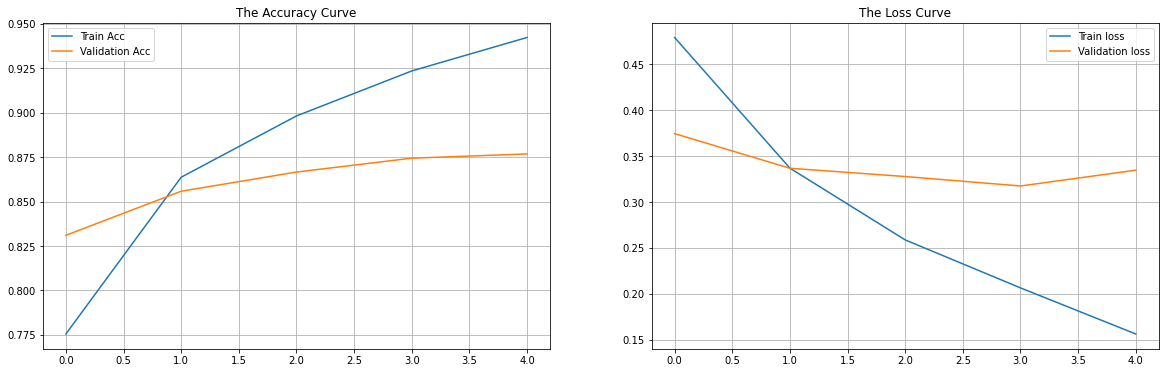

In [340]:
# Plot Loss and Accuracy curves
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("The Accuracy Curve")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("The Loss Curve")
plt.legend()
plt.grid()

plt.show()

In [341]:
# Finally predict on the Test dataset
test_h = model.init_hidden(batch_size)
test_losses = []
test_acc = 0.0

for inputs, labels in test_loader:
    test_h = tuple([each.data for each in test_h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, test_h = model(inputs, test_h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item()) 
    accuracy = acc(output,labels)
    test_acc += accuracy
    
final_test_loss = np.mean(test_losses)
final_test_acc = test_acc/len(test_loader.dataset)
print(f'\nFinal prediction on the Test dataset => Accuracy : {final_test_acc*100}')



Final prediction on the Test dataset => Accuracy : 88.24
